# **1.Loading data and Checking ARIMA assumptions for SARAL**

Condition 1: Data Should be univariate-This condition is satisfied because we are considering only one orbital element that is, Brouwer Mean Motion

Condition 2: Are there any missing values in the data?

In [ ]:
# !pip uninstall -y numpy scipy statsmodels pmdarima


# !pip install numpy==1.25.2 scipy==1.11.4 statsmodels==0.14.0 pmdarima==2.0.4

In [ ]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

In [ ]:
# Load data
df = pd.read_csv('/content/SARAL.csv')
df['timestamp'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index('timestamp', inplace=True)

# Check missing values
df['Brouwer mean motion'].isnull().sum()


0

Condition 3: Time Intervals should be regular



In [ ]:
time_deltas = df.index.to_series().diff().value_counts()
print(time_deltas.head())


timestamp
1 days 01:09:13.574592    2
1 days 07:51:22.839552    2
1 days 01:09:13.845889    2
1 days 01:09:13.938336    2
1 days 04:30:11.219040    2
Name: count, dtype: int64


As we can see from the output. The condition is not met. We are fixing this using interpolation

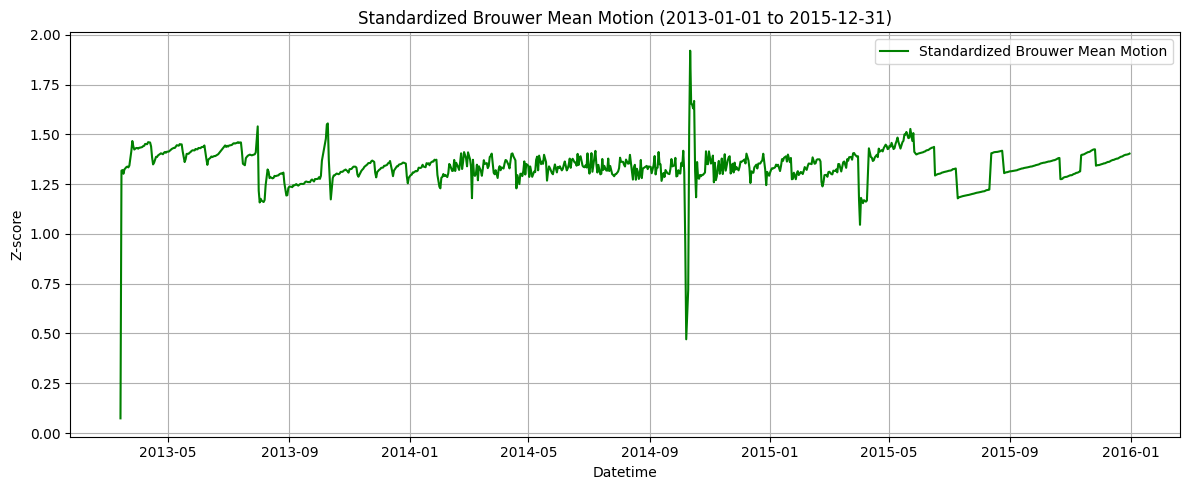

In [ ]:
#Parse the timestamp column
df['timestamp'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index('timestamp', inplace=True)

#Select the 'Brouwer mean motion' column
bmm_series = df['Brouwer mean motion']

#Step: Resampling
bmm_resampled = bmm_series.resample('D').mean()

#Using Linear Interpolation to fill the gaps
bmm_interpolated = bmm_resampled.interpolate(method='linear')

q1 = bmm_interpolated.quantile(0.25)
q3 = bmm_interpolated.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 0.8 * iqr  # instead of 1.5
upper_bound = q3 + 0.8 * iqr

bmm_outremoved = bmm_interpolated[(bmm_interpolated >= lower_bound) & (bmm_interpolated <= upper_bound)]

# Repair gaps
bmm_cleaned = bmm_outremoved.interpolate(method='linear')

# Standardize
bmm_standardized = (bmm_cleaned - bmm_cleaned.mean()) / bmm_cleaned.std()


#Define time window
start_date = '2013-01-01'
end_date = '2015-12-31'

#Filter standardized data
standardized_window = bmm_standardized[start_date:end_date]

#Plot
plt.figure(figsize=(12, 5))
plt.plot(standardized_window, label='Standardized Brouwer Mean Motion', color='green')
plt.title(f'Standardized Brouwer Mean Motion ({start_date} to {end_date})')
plt.xlabel('Datetime')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Condition 4: The data should be stationery. For ARIMA it is necessary that mean and variance are consistent  over time (meaning they dont have any trend, seasonality and changing variance)

In [ ]:
# Run ADF Test
result = adfuller(bmm_standardized.dropna())

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] < 0.05:
    print("✅ The series is stationary (p < 0.05)")
else:
    print("❌ The series is NOT stationary (p ≥ 0.05)")


ADF Statistic: -1.6609543710342862
p-value: 0.4513338471332242
❌ The series is NOT stationary (p ≥ 0.05)


The series is not stationary. So we are differencing the series

In [ ]:
# Apply differencing
bmm_diff1 = bmm_standardized.diff().dropna()

# Run ADF Test again
result = adfuller(bmm_diff1)

print(f"ADF Statistic after differencing: {result[0]}")
print(f"p-value after differencing: {result[1]}")

if result[1] < 0.05:
    print("✅ The differenced series is stationary (p < 0.05)")
else:
    print("❌ The differenced series is NOT stationary (p ≥ 0.05)")


ADF Statistic after differencing: -26.936282435088863
p-value after differencing: 0.0
✅ The differenced series is stationary (p < 0.05)


In [ ]:
# Perform ADF test on the DIFFERENCED standardized series
bmm_standardized_diff = bmm_standardized.diff().dropna()
adf_result = adfuller(bmm_standardized_diff)

#Print ADF test results
print("\nAugmented Dickey-Fuller Test Results:")
print(f"ADF Statistic          : {adf_result[0]}")
print(f"p-value                : {adf_result[1]}")
print(f"# Lags Used            : {adf_result[2]}")
print(f"# Observations Used    : {adf_result[3]}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

# STEP 13: Conclusion based on p-value
alpha = 0.05
if adf_result[1] < alpha:
    print("\n✅ Conclusion: The DIFFERENCED series is likely **stationary** (reject H₀).")
else:
    print("\n❌ Conclusion: The DIFFERENCED series is likely **non-stationary** (fail to reject H₀).")




Augmented Dickey-Fuller Test Results:
ADF Statistic          : -26.936282435088863
p-value                : 0.0
# Lags Used            : 5
# Observations Used    : 3465
Critical Values:
   1%: -3.4322386438846837
   5%: -2.862374495027001
   10%: -2.567214216645948

✅ Conclusion: The DIFFERENCED series is likely **stationary** (reject H₀).


Condition 5: Choose d,p,q values

Since our data is already stationery, we choose d=0

Choosing p and q using 'auto_arima'

In [ ]:
!pip install pmdarima


In [ ]:
from pmdarima.arima import auto_arima
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
import warnings
warnings.filterwarnings("ignore")

# Input series (already standardized and interpolated)
series_for_arima = bmm_standardized.dropna()

# 🔍 Automatically determine best ARIMA(p,d,q) using full search
from pmdarima import auto_arima

# Run auto_arima
model_auto = auto_arima(
    bmm_standardized,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=1,           # Fixed differencing based on your ADF test
    seasonal=False, # No seasonality in satellite orbits
    trace=True,    # Show the search process
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True   # Faster search
)



print("\n✅ Best ARIMA model selected by auto_arima:")
print(model_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9967.842, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9969.601, Time=1.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9969.870, Time=1.87 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9969.824, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9968.979, Time=7.63 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-9971.123, Time=2.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-9969.282, Time=3.33 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-9974.809, Time=5.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-9979.018, Time=3.11 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-9977.667, Time=8.66 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-9979.365, Time=3.90 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-9978.787, Time=3.21 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-9977.391, Time=2.24 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=-9977.741, Time=3.06 sec
 ARIMA(0,1,5)(0,0,0

Hence p=2, d=1, q=1

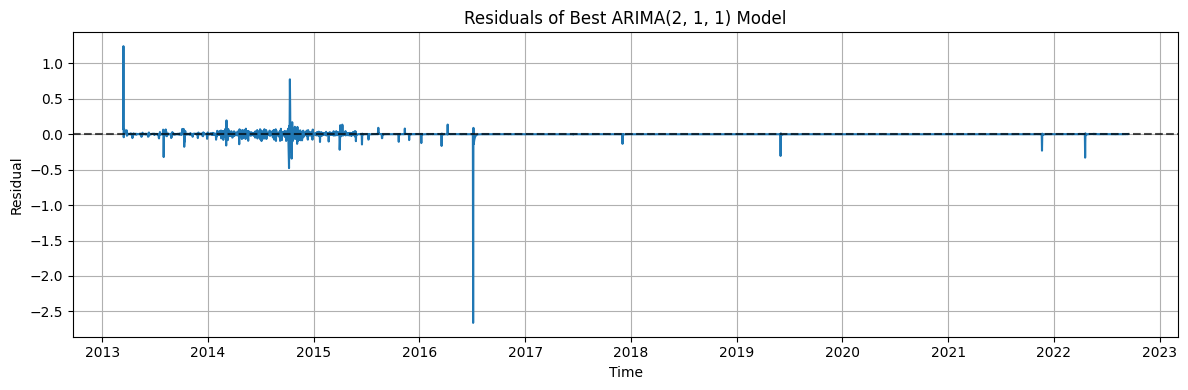

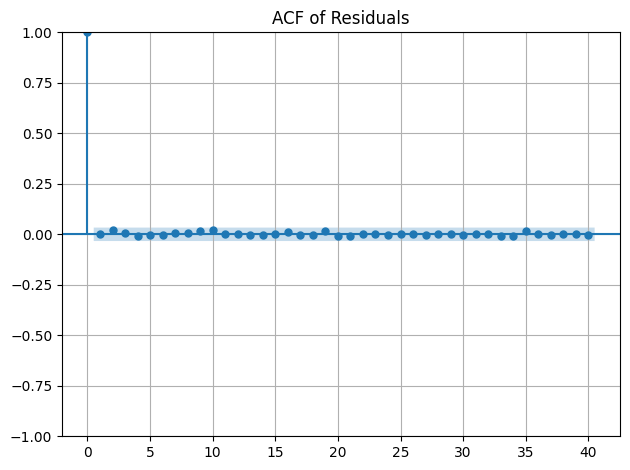

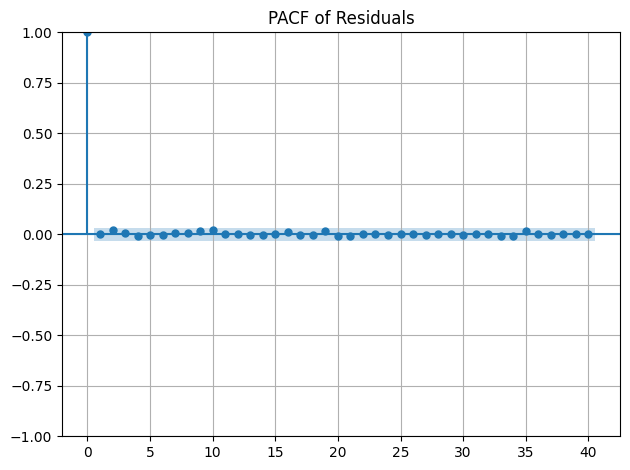

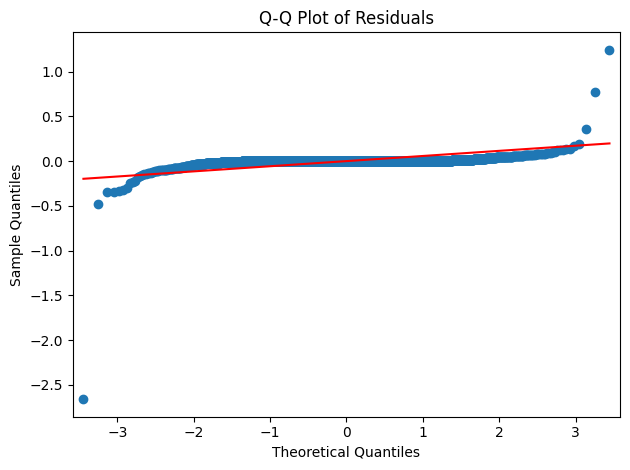


📊 Ljung-Box Test Results:
     lb_stat  lb_pvalue
10  4.713304   0.909489
20  6.271995   0.998477
30  6.897948   0.999996

✅ Conclusion: Residuals resemble **white noise** (no significant autocorrelation).


In [ ]:
# Fit the selected model using statsmodels for residual analysis
best_params = model_auto.order
best_model = sm.tsa.ARIMA(series_for_arima, order=best_params).fit()

# Extract residuals
residuals = best_model.resid.dropna()

# 1. Residual time series plot
plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.title(f'Residuals of Best ARIMA{best_params} Model')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. ACF plot
plot_acf(residuals, lags=40)
plt.title('ACF of Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. PACF plot
plot_pacf(residuals, lags=40, method='ywm')
plt.title('PACF of Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Q-Q Plot
qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

# 5. Ljung-Box Test
ljung_box = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("\n📊 Ljung-Box Test Results:")
print(ljung_box)

# 6. Conclusion based on p-values
if (ljung_box['lb_pvalue'] > 0.05).all():
    print("\n✅ Conclusion: Residuals resemble **white noise** (no significant autocorrelation).")
else:
    print("\n❌ Conclusion: Residuals show **autocorrelation** (not white noise). Model may be misspecified.")

# **2.Qualitative Analysis**

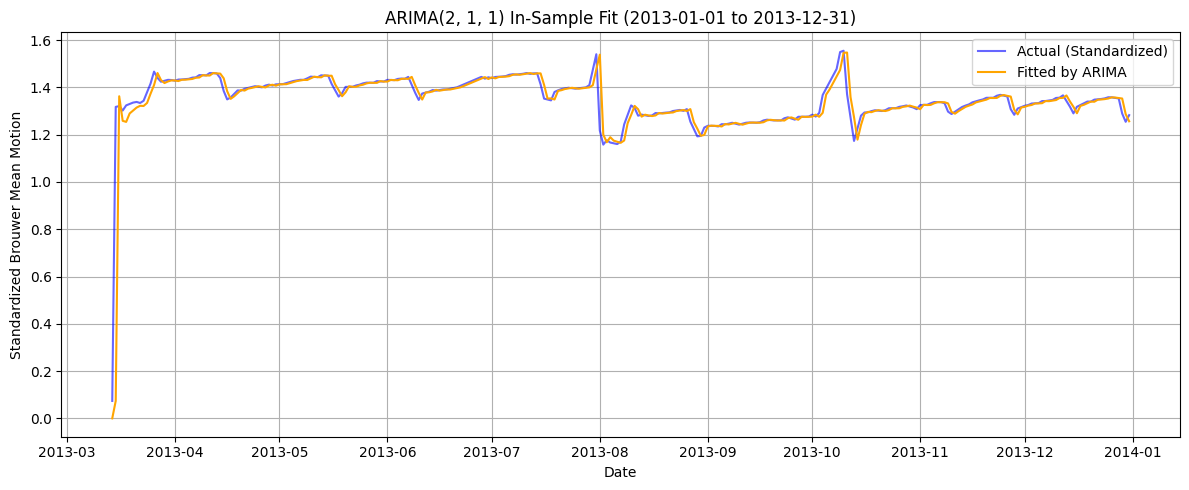

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

#Refit the best ARIMA model on standardized series
model_trad = ARIMA(bmm_standardized, order=best_params)
model_trad_fit = model_trad.fit()

#Get in-sample fitted values
fitted_values = model_trad_fit.predict(start=0, end=len(bmm_standardized)-1)

#Define time interval
start_date = '2013-01-01'
end_date = '2013-12-31'

#Filter both actual and fitted series to the time window
actual_window = bmm_standardized[start_date:end_date]
fitted_window = fitted_values[start_date:end_date]

#Plot only the windowed data (y-axis adjusts dynamically)
plt.figure(figsize=(12, 5))
plt.plot(actual_window, label='Actual (Standardized)', color='blue', alpha=0.6)
plt.plot(fitted_window, label='Fitted by ARIMA', color='orange')
plt.title(f'ARIMA{best_params} In-Sample Fit ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Standardized Brouwer Mean Motion')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


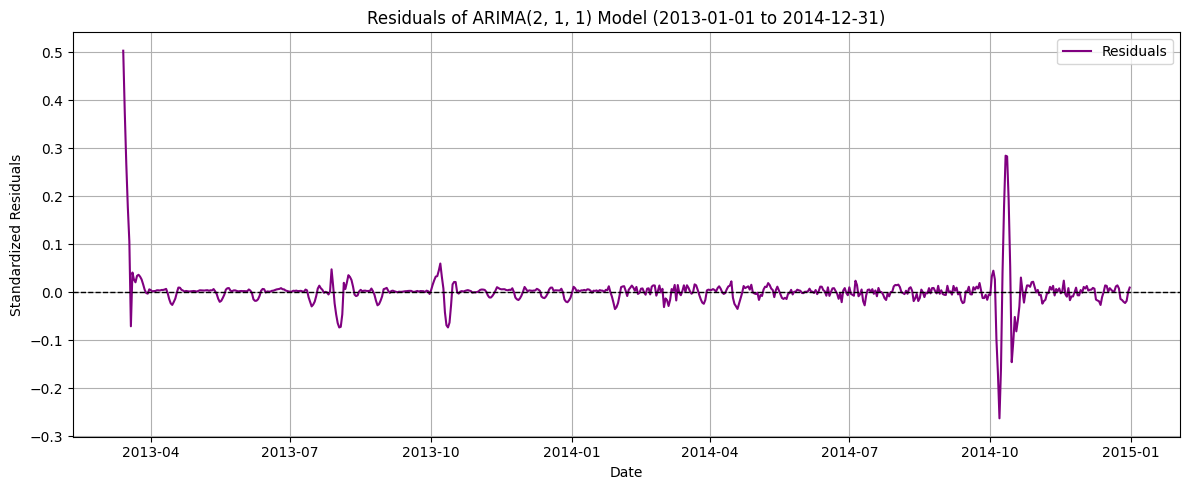

In [ ]:
from scipy.signal import savgol_filter

#Get residuals from the best ARIMA model

residuals = model_trad_fit.resid

#Smooth the residuals (window length must be odd and < len(data))
smoothed_residuals = pd.Series(
    savgol_filter(residuals, window_length=9, polyorder=2),
    index=residuals.index
)


#Define the desired time interval
start_date = '2013-01-01'
end_date = '2014-12-31'

#Filter residuals to that time interval
residuals_window = smoothed_residuals[start_date:end_date]

#Plot residuals (auto y-axis)
plt.figure(figsize=(12, 5))
plt.plot(residuals_window, label='Residuals', color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title(f'Residuals of ARIMA{best_params} Model ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Standardized Residuals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


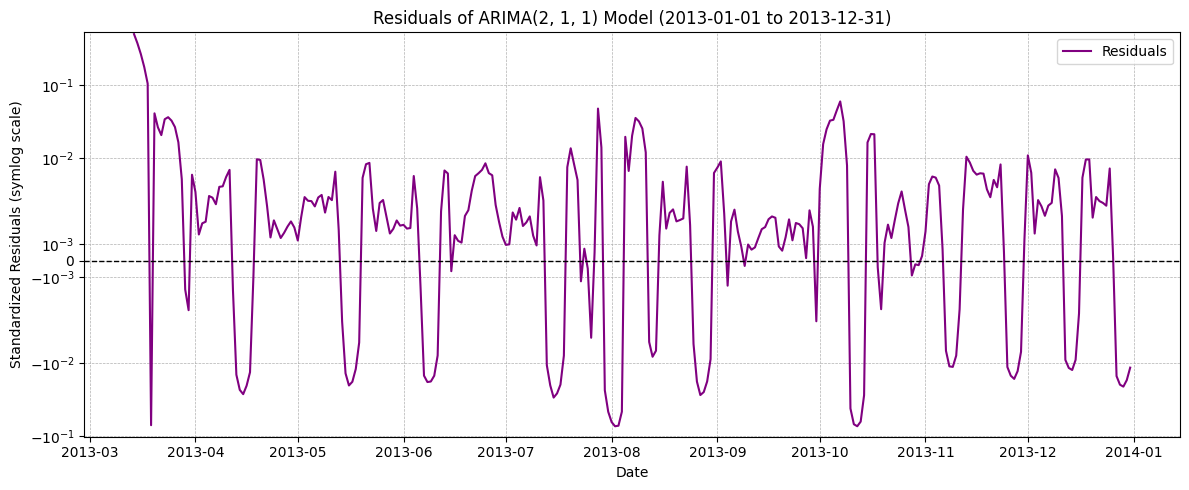

In [ ]:
#Define the desired time interval
start_date = '2013-01-01'
end_date = '2013-12-31'

#Filter residuals to that time interval
residuals_window = smoothed_residuals[start_date:end_date]

#Plot residuals with symmetric logarithmic y-scale
plt.figure(figsize=(12, 5))
plt.plot(residuals_window, label='Residuals', color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=1)

#Apply symlog scaling for better visualization
plt.yscale('symlog', linthresh=0.005)

# Labels and formatting
plt.title(f'Residuals of ARIMA{best_params} Model ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Standardized Residuals (symlog scale)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


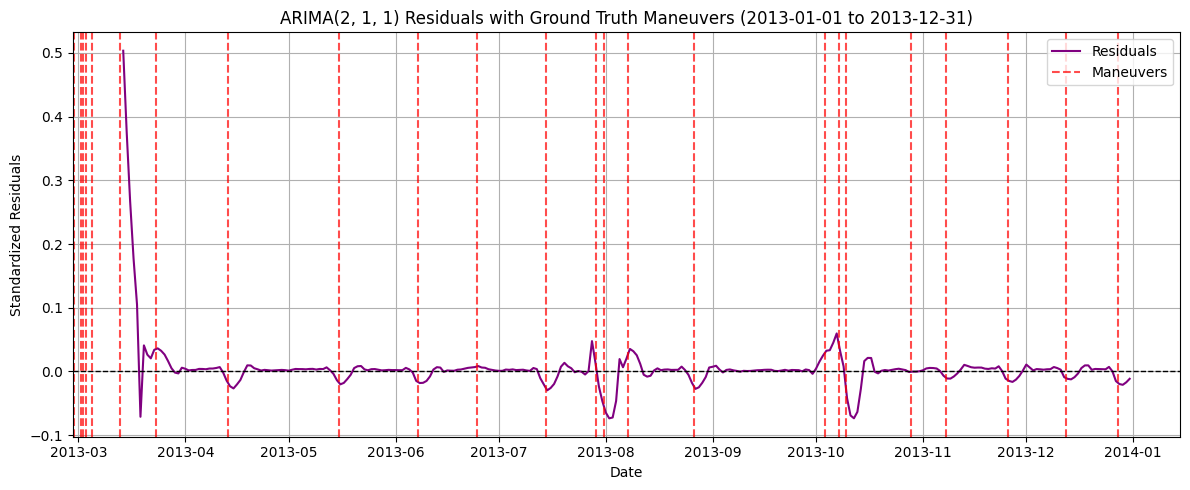

In [ ]:
# Step 1: Load maneuver ground truth
truth_df = pd.read_excel("/content/cleaned_srlman.xlsx")

# Step 2: Create maneuver timestamps by combining date and time
truth_df["Maneuver_Timestamp"] = pd.to_datetime(
    truth_df["Start Date"].astype(str) + " " + truth_df["Start Time"].astype(str)
)

# Step 3: Define time window
start_date = '2013-01-01'
end_date = '2013-12-31'

# Step 4: Filter maneuver timestamps to the defined window
filtered_maneuvers = truth_df[
    (truth_df["Maneuver_Timestamp"] >= start_date) &
    (truth_df["Maneuver_Timestamp"] <= end_date)
]["Maneuver_Timestamp"]

# Step 5: Get raw residuals from ARIMA model
residuals = model_trad_fit.resid

# Step 6: Apply Savitzky-Golay smoothing to residuals
# Ensure window_length is odd and less than the length of residuals
smoothed_residuals = pd.Series(
    savgol_filter(residuals, window_length=9, polyorder=2),
    index=residuals.index
)

# Step 5: Get residuals from the best ARIMA model for the same window
residuals_window = smoothed_residuals[start_date:end_date]

# Plot
plt.figure(figsize=(12, 5))
res_line, = plt.plot(residuals_window, label='Residuals', color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Plot one representative maneuver line for legend
man_line = plt.axvline(x=filtered_maneuvers.iloc[0], color='red', linestyle='--', alpha=0.7, label='Maneuvers')

# Plot the rest (without labels)
for ts in filtered_maneuvers.iloc[1:]:
    plt.axvline(x=ts, color='red', linestyle='--', alpha=0.7)

# Formatting
plt.title(f'ARIMA{best_params} Residuals with Ground Truth Maneuvers ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Standardized Residuals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



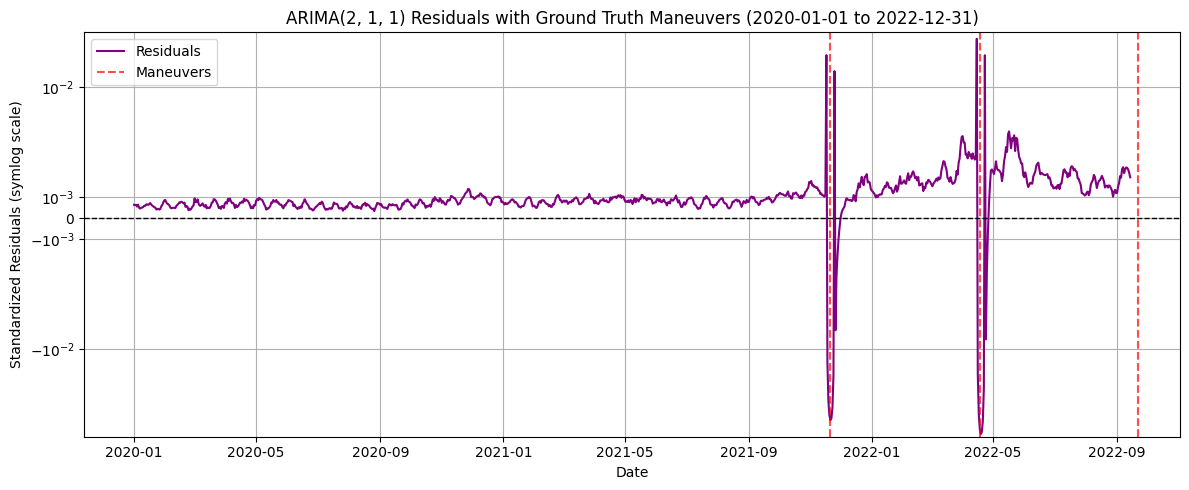

In [ ]:
# Step 1: Load maneuver ground truth
truth_df = pd.read_excel("/content/cleaned_srlman.xlsx")

# Step 2: Create maneuver timestamps by combining date and time
truth_df["Maneuver_Timestamp"] = pd.to_datetime(
    truth_df["Start Date"].astype(str) + " " + truth_df["Start Time"].astype(str)
)

# Step 3: Define time window
start_date = '2020-01-01'
end_date = '2022-12-31'

# Step 4: Filter maneuver timestamps to the defined window
filtered_maneuvers = truth_df[
    (truth_df["Maneuver_Timestamp"] >= start_date) &
    (truth_df["Maneuver_Timestamp"] <= end_date)
]["Maneuver_Timestamp"]

# Step 5: Get raw residuals from ARIMA model
residuals = model_trad_fit.resid

# Step 6: Apply Savitzky-Golay smoothing to residuals
# Ensure window_length is odd and less than the length of residuals
smoothed_residuals = pd.Series(
    savgol_filter(residuals, window_length=9, polyorder=2),
    index=residuals.index
)

# Step 7: Get residuals for the time window
residuals_window = smoothed_residuals[start_date:end_date]

# Step 8: Plot
plt.figure(figsize=(12, 5))
res_line, = plt.plot(residuals_window, label='Residuals', color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Set symmetric log scale on y-axis 🔥
plt.yscale('symlog', linthresh=0.005)
# You can adjust linthresh if you want to control "how quickly" log kicks in

# Plot one representative maneuver line for legend
man_line = plt.axvline(x=filtered_maneuvers.iloc[0], color='red', linestyle='--', alpha=0.7, label='Maneuvers')

# Plot the rest (without labels)
for ts in filtered_maneuvers.iloc[1:]:
    plt.axvline(x=ts, color='red', linestyle='--', alpha=0.7)

# Formatting
plt.title(f'ARIMA{best_params} Residuals with Ground Truth Maneuvers ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Standardized Residuals (symlog scale)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **3.Quantitative Analysis**

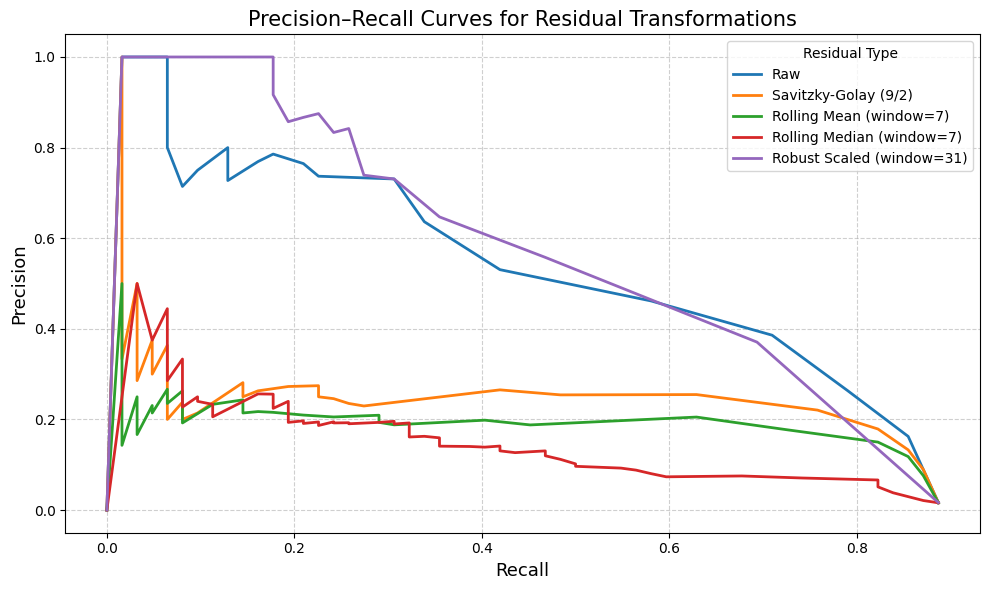


=== ARIMA Residual Evaluation Summary ===


,Residual Type,Optimal Threshold,Precision,Recall,F1,TP,FP,FN,PR AUC
0,Raw,0.071527,0.461538,0.580645,0.514286,36,42,26,0.487834
1,Robust Scaled (window=31),12.309464,0.557692,0.467742,0.508772,29,23,33,0.518979
2,Savitzky-Golay (9/2),0.023022,0.254902,0.629032,0.362791,39,114,23,0.222575
3,Rolling Mean (window=7),0.014551,0.205263,0.629032,0.309524,39,151,23,0.171900
4,Rolling Median (window=7),0.015102,0.192308,0.322581,0.240964,20,84,42,0.128493


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from datetime import timedelta

# --- Utility: Robust rolling MAD ---
def rolling_mad(x):
    med = np.median(x)
    return np.median(np.abs(x - med))

# --- Detection Function without TN ---
def compute_prf_simple(
    residual_series: pd.Series,
    ground_truth_timestamps: pd.Series,
    threshold: float,
    matching_window_days: float = 3.0
):
    detections = residual_series[residual_series > threshold]
    detection_times = detections.index.sort_values()

    TP, FP, matched_gt = 0, 0, set()
    for det_time in detection_times:
        for i, gt_time in enumerate(ground_truth_timestamps):
            if i in matched_gt:
                continue
            if abs(det_time - gt_time) <= pd.Timedelta(days=matching_window_days):
                TP += 1
                matched_gt.add(i)
                break
        else:
            FP += 1

    FN = len(ground_truth_timestamps) - len(matched_gt)

    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    return precision, recall, f1, TP, FP, FN

# --- Residual Preparations ---
residuals = model_trad_fit.resid
resid_types = {
    "Raw": residuals.abs(),
    "Savitzky-Golay (9/2)": pd.Series(
        savgol_filter(residuals, window_length=9, polyorder=2),
        index=residuals.index).abs(),
    "Rolling Mean (window=7)": residuals.rolling(window=7, center=True, min_periods=1).mean().abs(),
    "Rolling Median (window=7)": residuals.rolling(window=7, center=True, min_periods=1).median().abs(),
    "Robust Scaled (window=31)": (
        ((residuals - residuals.rolling(window=31, center=True, min_periods=1).median()) /
         (residuals.rolling(window=31, center=True, min_periods=1).apply(rolling_mad, raw=True) + 1e-8)).abs()
    ),
}

# --- Evaluation Loop ---
summary_rows = []
resid_metrics_dfs = {}
matching_window_days = 3.0
series_ground_truth_manoeuvre_timestamps = truth_df["Maneuver_Timestamp"]

plt.figure(figsize=(10, 6))

for name, abs_resid in resid_types.items():
    # Remove zeros and near-zero values using a small quantile cutoff
    abs_resid_clean = abs_resid[abs_resid > abs_resid.quantile(0.01)]

    # Generate thresholds between 1st percentile and max
    thresholds = np.linspace(abs_resid_clean.min(), abs_resid_clean.max(), 150)

    pr_points = []
    metrics = []

    for threshold in thresholds:
        precision, recall, f1, TP, FP, FN = compute_prf_simple(
            abs_resid,
            series_ground_truth_manoeuvre_timestamps,
            threshold,
            matching_window_days=matching_window_days
        )
        pr_points.append((recall, precision))
        metrics.append((threshold, precision, recall, f1, TP, FP, FN))

    metrics_df = pd.DataFrame(metrics, columns=["Threshold", "Precision", "Recall", "F1", "TP", "FP", "FN"])
    resid_metrics_dfs[name] = metrics_df.copy()

    best_idx = metrics_df["F1"].idxmax()
    best_row = metrics_df.loc[best_idx]

    pr_points_arr = np.array(pr_points)
    sorted_idx = np.argsort(pr_points_arr[:, 0])  # sort by recall
    auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])  # PR AUC

    summary_rows.append({
        "Residual Type": name,
        "Optimal Threshold": best_row["Threshold"],
        "Precision": best_row["Precision"],
        "Recall": best_row["Recall"],
        "F1": best_row["F1"],
        "TP": int(best_row["TP"]),
        "FP": int(best_row["FP"]),
        "FN": int(best_row["FN"]),
        "PR AUC": auc_pr
    })

    plt.plot(pr_points_arr[:, 0], pr_points_arr[:, 1], label=f"{name}", linewidth=2)

# --- Final PR Plot ---
plt.xlabel("Recall", fontsize=13)
plt.ylabel("Precision", fontsize=13)
plt.title("Precision–Recall Curves for Residual Transformations", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Residual Type", fontsize=10)
plt.tight_layout()
plt.show()

# --- Summary Table ---
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values("F1", ascending=False).reset_index(drop=True)

from IPython.display import display
print("\n=== ARIMA Residual Evaluation Summary ===")
display(summary_df)
